## Framing the problem

- We need to predict the outcome of pokemon battles in order to later choose the best pokemons.
- Data suggests a supervised problem.
- Model should output Battle Result near the true Battle Result, performance measure yet unclear.
- In case of a lack of data, external pokemon battle simulators might be of use.

## Data Exploration

- Battle Results: 2.7M Recorded Battle outcomes,
    - Level is in Range [1, 99]
    - WeatherAndTime is in {'Windy', 'Unknown', 'Sunshine', 'Rain', 'Night'}, 20% unknown
    - Less than 5% of pokemons are legendary
    - Attack, Defense, etc.. These Stats have few extremes, and are concentrated on the lower end
    - Sp_Atk stands for Special_Attack, similar range as generic attack field, same goes for Sp_Def
    - The Pokemon Types of the submission file, don't appeaer in the Battle Results. Hence the name is useless.
    - Battle Result is the target attribute.
- Weakness Pokemon: A Matrix indicating performance of pokemon types against each other.

- If I solved the task manually, I would relly on Weaknesses, but how to incorporate this into model? Perhaps directly feed advantage, on don't feed types at all?


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
catalog = context.catalog

In [5]:
Submission = catalog.load('Submission')
AvailablePokemons = catalog.load('AvailablePokemons')
BattleResults = catalog.load('Battle_Results')
Weakness_Pokemon = catalog.load('Weakness_Pokemon')
AllPokemons = catalog.load('All_Pokemons')

2020-05-21 22:36:34,264 - kedro.io.data_catalog - INFO - Loading data from `Submission` (CSVDataSet)...
2020-05-21 22:36:34,279 - kedro.io.data_catalog - INFO - Loading data from `AvailablePokemons` (CSVDataSet)...
2020-05-21 22:36:34,285 - kedro.io.data_catalog - INFO - Loading data from `Battle_Results` (CSVDataSet)...
2020-05-21 22:36:39,344 - kedro.io.data_catalog - INFO - Loading data from `Weakness_Pokemon` (CSVDataSet)...
2020-05-21 22:36:39,354 - kedro.io.data_catalog - INFO - Loading data from `All_Pokemons` (CSVDataSet)...


### Battle Results

In [5]:
BattleResults.head()

,Name_1,Level_1,Price_1,HP_1,Attack_1,Defense_1,Sp_Atk_1,Sp_Def_1,Speed_1,Legendary_1,...,Price_2,HP_2,Attack_2,Defense_2,Sp_Atk_2,Sp_Def_2,Speed_2,Legendary_2,WeatherAndTime,BattleResult
0,Metapod,30,441,150,36,103,47,47,58,False,...,1589,262,393,306,164,211,253,False,Windy,-262
1,Pinsir,36,1227,196,304,237,129,164,197,False,...,1583,547,127,365,172,172,200,False,Unknown,-424
2,Metapod,15,297,92,26,73,33,33,40,False,...,4913,821,1208,947,504,652,781,False,Windy,-821
3,Pinsir,40,1401,228,346,270,146,187,224,False,...,588,202,47,138,63,63,75,False,Unknown,214
4,Pinsir,12,634,91,157,124,70,86,106,False,...,381,126,32,90,41,41,51,False,Windy,41


In [8]:
BattleResults.loc[BattleResults["Name_2"]=="Mewtwo"]

,Name_1,Level_1,Price_1,HP_1,Attack_1,Defense_1,Sp_Atk_1,Sp_Def_1,Speed_1,Legendary_1,...,Price_2,HP_2,Attack_2,Defense_2,Sp_Atk_2,Sp_Def_2,Speed_2,Legendary_2,WeatherAndTime,BattleResult


In [18]:
BattleResults.loc[BattleResults["Legendary_2"]==True].shape

(56240, 22)

In [17]:
56327 / BattleResults.shape[0]

0.020714830262106392

In [14]:
BattleResults.shape[0]

2719163

In [6]:
BattleResults.Name_1.unique()

array(['Metapod', 'Pinsir', 'Scyther', 'Butterfree', 'Parasect', 'Paras',
       'Beedrill', 'Venonat', 'Venomoth', 'Kakuna', 'Weedle', 'Dratini',
       'Dragonair', 'Dragonite', 'Electrode', 'Pikachu', 'Voltorb',
       'Jolteon', 'Electabuzz', 'Zapdos', 'Magnemite', 'Magneton',
       'Clefable', 'Clefairy', 'Primeape', 'Hitmonlee', 'Machoke',
       'Mankey', 'Machamp', 'Machop', 'Hitmonchan', 'Ponyta',
       'Charmander', 'Charmeleon', 'Ninetales', 'Magmar', 'Arcanine',
       'Growlithe', 'Flareon', 'Vulpix', 'Rapidash', 'Moltres',
       'Charizard', 'Gengar', 'Gastly', 'Haunter', 'Tangela',
       'Weepinbell', 'Ivysaur', 'Oddish', 'Vileplume', 'Gloom',
       'Victreebel', 'Bulbasaur', 'Bellsprout', 'Exeggutor', 'Exeggcute',
       'Sandslash', 'Diglett', 'Cubone', 'Dugtrio', 'Marowak',
       'Sandshrew', 'Rhydon', 'Rhyhorn', 'Articuno', 'Jynx', 'Snorlax',
       'Rattata', 'Meowth', 'Lickitung', 'Kangaskhan', 'Persian', 'Ditto',
       'Tauros', 'Porygon', 'Eevee', 'Raticat

In [9]:
BattleResults.describe()

,Level_1,Price_1,HP_1,Attack_1,Defense_1,Sp_Atk_1,Sp_Def_1,Speed_1,Level_2,Price_2,HP_2,Attack_2,Defense_2,Sp_Atk_2,Sp_Def_2,Speed_2,BattleResult
count,2.719163e+06,2.719163e+06,2.719163e+06,2.719163e+06,2.719163e+06,2.719163e+06,2.719163e+06,2.719163e+06,2.719163e+06,2.719163e+06,2.719163e+06,2.719163e+06,2.719163e+06,2.719163e+06,2.719163e+06,2.719163e+06,2.719163e+06
mean,5.000841e+01,1.780009e+03,3.329481e+02,3.043974e+02,2.872659e+02,2.837187e+02,2.810636e+02,2.906155e+02,4.999958e+01,1.779824e+03,3.329161e+02,3.043613e+02,2.872629e+02,2.836855e+02,2.810360e+02,2.905625e+02,-1.003408e-01
std,2.857987e+01,1.328518e+03,2.620586e+02,2.510274e+02,2.428663e+02,2.435758e+02,2.299945e+02,2.423285e+02,2.857592e+01,1.328581e+03,2.620985e+02,2.509934e+02,2.428696e+02,2.436107e+02,2.300242e+02,2.423243e+02,4.847676e+02
min,1.000000e+00,1.950000e+02,1.000000e+01,5.000000e+00,5.000000e+00,1.500000e+01,2.000000e+01,1.500000e+01,1.000000e+00,1.950000e+02,1.000000e+01,5.000000e+00,5.000000e+00,1.500000e+01,2.000000e+01,1.500000e+01,-2.312000e+03
25%,2.500000e+01,7.290000e+02,1.310000e+02,1.190000e+02,1.110000e+02,1.090000e+02,1.100000e+02,1.130000e+02,2.500000e+01,7.290000e+02,1.300000e+02,1.190000e+02,1.110000e+02,1.090000e+02,1.100000e+02,1.130000e+02,-3.470000e+02
50%,5.000000e+01,1.356000e+03,2.530000e+02,2.220000e+02,2.070000e+02,2.000000e+02,2.030000e+02,2.080000e+02,5.000000e+01,1.356000e+03,2.530000e+02,2.220000e+02,2.070000e+02,2.000000e+02,2.030000e+02,2.080000e+02,-1.000000e+00
75%,7.500000e+01,2.509000e+03,4.720000e+02,4.210000e+02,3.910000e+02,3.820000e+02,3.840000e+02,3.960000e+02,7.500000e+01,2.509000e+03,4.720000e+02,4.210000e+02,3.920000e+02,3.820000e+02,3.840000e+02,3.960000e+02,3.470000e+02
max,9.900000e+01,8.106000e+03,2.312000e+03,1.865000e+03,2.336000e+03,1.685000e+03,1.508000e+03,1.595000e+03,9.900000e+01,8.106000e+03,2.312000e+03,1.865000e+03,2.336000e+03,1.685000e+03,1.508000e+03,1.595000e+03,2.277000e+03


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d7d7160>,
      dtype=object)

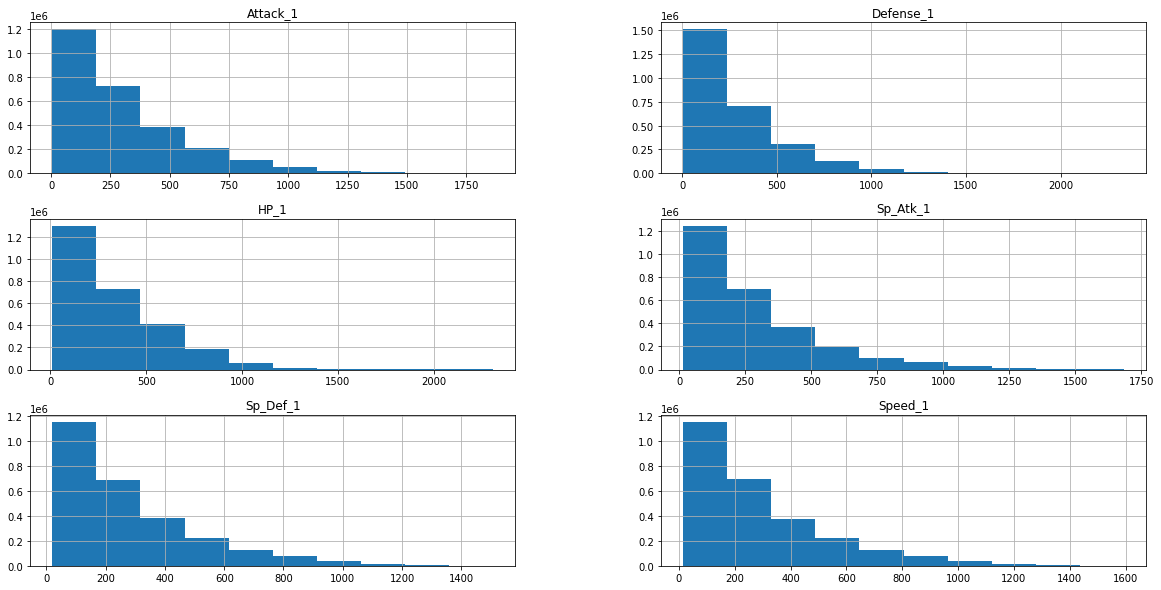

In [19]:
BattleResults.hist(column=["HP_1", "Attack_1", "Defense_1", "Speed_1", "Sp_Def_1", "Sp_Atk_1"], figsize=(20, 10))

In [5]:
BattleResults.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2719163 entries, 0 to 2719162
Data columns (total 22 columns):
Name_1            object
Level_1           int64
Price_1           int64
HP_1              int64
Attack_1          int64
Defense_1         int64
Sp_Atk_1          int64
Sp_Def_1          int64
Speed_1           int64
Legendary_1       bool
Name_2            object
Level_2           int64
Price_2           int64
HP_2              int64
Attack_2          int64
Defense_2         int64
Sp_Atk_2          int64
Sp_Def_2          int64
Speed_2           int64
Legendary_2       bool
WeatherAndTime    object
BattleResult      int64
dtypes: bool(2), int64(17), object(3)
memory usage: 420.1+ MB


In [26]:
BattleResults.isnull().values.any()

False

### Weaknesses

In [4]:
Weakness_Pokemon

,Types,Normal,Fire,Water,Electric,Grass,Ice,Fighting,Poison,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy
0,Normal,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.6,0.6,1.0,1.0,0.6,1.0
1,Fire,1.0,0.6,0.6,1.0,50.0,6.0,1.0,1.0,1.0,1.0,1.0,6.0,0.6,1.0,0.6,1.0,6.0,1.0
2,Water,1.0,20.0,0.6,1.0,0.6,1.0,1.0,1.0,6.0,1.0,1.0,1.0,6.0,1.0,0.6,1.0,1.0,1.0
3,Electric,1.0,1.0,6.0,0.6,0.6,1.0,1.0,1.0,0.6,6.0,1.0,1.0,1.0,1.0,0.6,1.0,1.0,1.0
4,Grass,1.0,0.6,6.0,1.0,0.6,1.0,1.0,0.6,6.0,0.6,1.0,0.6,6.0,1.0,0.6,1.0,0.6,1.0
5,Ice,1.0,0.6,0.6,1.0,6.0,0.6,1.0,1.0,6.0,6.0,1.0,1.0,1.0,1.0,6.0,1.0,0.6,1.0
6,Fighting,6.0,1.0,1.0,1.0,1.0,6.0,1.0,0.6,1.0,0.6,0.6,0.6,6.0,0.6,1.0,6.0,6.0,0.6
7,Poison,1.0,1.0,1.0,1.0,6.0,1.0,1.0,0.6,0.6,1.0,1.0,1.0,0.6,0.6,1.0,1.0,0.6,6.0
8,Ground,1.0,6.0,1.0,6.0,0.6,1.0,1.0,6.0,1.0,0.6,1.0,0.6,6.0,1.0,1.0,1.0,6.0,1.0
9,Flying,1.0,1.0,1.0,0.6,6.0,1.0,6.0,1.0,1.0,1.0,1.0,6.0,0.6,1.0,1.0,1.0,0.6,1.0


### Available Pokemons

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x125635240>,
      dtype=object)

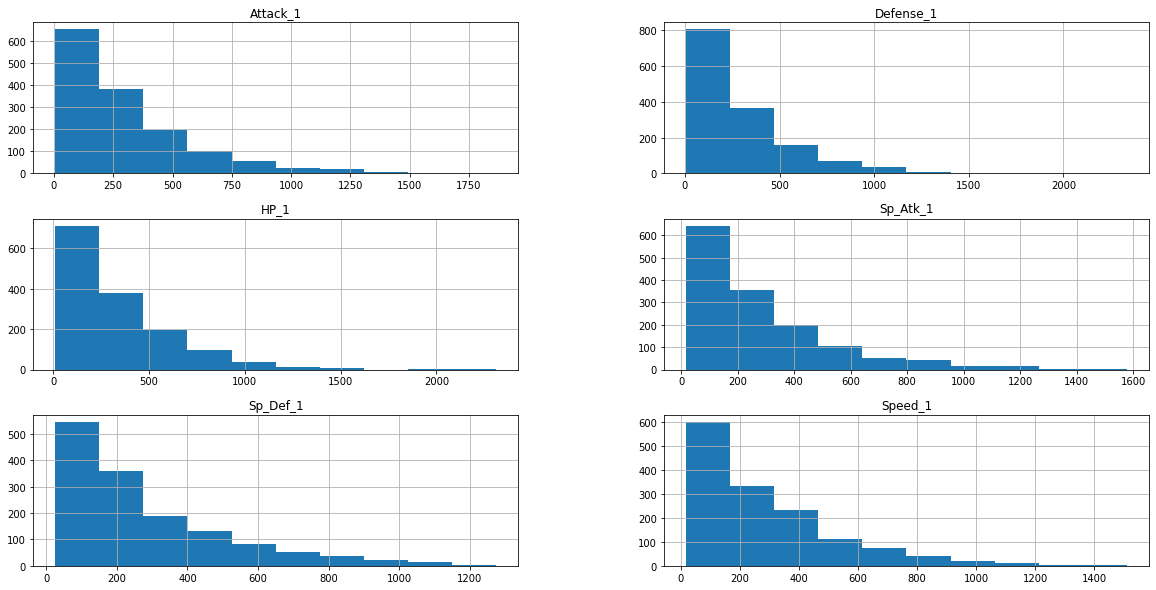

In [23]:
AvailablePokemons.hist(column=["HP_1", "Attack_1", "Defense_1", "Speed_1", "Sp_Def_1", "Sp_Atk_1"], figsize=(20, 10))

In [4]:
Submission

,Name_2,Level_2,WeatherAndTime,Price_2,HP_2,Attack_2,Defense_2,Sp_Atk_2,Sp_Def_2,Speed_2,Legendary_2,SelectedPokemonID
0,Caterpie,5,Rain,216,50,33,39,22,22,50,False,0
1,Golem,42,Windy,1407,258,332,362,148,184,123,False,0
2,Krabby,50,Rain,1287,183,405,333,91,91,184,False,0
3,Mewtwo,73,Unknown,4107,689,671,522,935,522,768,True,0
4,Raichu,41,Night,1415,227,252,150,252,228,306,False,0
5,Venusaur,30,Night,1111,177,173,174,208,208,171,False,0


In [11]:
All_Pokemons.head()

,ID,Name,Type_1,Type_2
0,1,Bulbasaur,Grass,Poison
1,2,Ivysaur,Grass,Poison
2,3,Venusaur,Grass,Poison
3,4,Charmander,Fire,NaN
4,5,Charmeleon,Fire,NaN


In [16]:
AvailablePokemons.describe()

,Level_1,Price_1,HP_1,Attack_1,Defense_1,Sp_Atk_1,Sp_Def_1,Speed_1,SelectedPokemonID
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,49.555556,1780.164583,335.111806,306.461806,286.778472,282.377083,281.086111,288.349306,720.500000
std,28.526052,1365.719899,278.382700,266.739844,245.495517,245.183504,234.714517,241.031097,415.836506
min,1.000000,205.000000,10.000000,5.000000,5.000000,17.000000,25.000000,18.000000,1.000000
25%,25.000000,721.750000,128.000000,115.000000,107.750000,111.000000,109.000000,109.750000,360.750000
50%,49.000000,1328.500000,243.500000,220.000000,205.000000,194.000000,200.000000,203.500000,720.500000
75%,74.000000,2457.750000,464.000000,411.500000,381.250000,383.000000,387.250000,390.750000,1080.250000
max,99.000000,7526.000000,2312.000000,1865.000000,2336.000000,1578.000000,1275.000000,1511.000000,1440.000000


In [15]:
AllPokemons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 4 columns):
ID        151 non-null int64
Name      151 non-null object
Type_1    151 non-null object
Type_2    65 non-null object
dtypes: int64(1), object(3)
memory usage: 4.8+ KB


In [20]:
AllPokemons.head()

,ID,Name,Type_1,Type_2
0,1,Bulbasaur,Grass,Poison
1,2,Ivysaur,Grass,Poison
2,3,Venusaur,Grass,Poison
3,4,Charmander,Fire,NaN
4,5,Charmeleon,Fire,NaN


### Correlations

In [11]:
corr_matrix = BattleResults.corr()

In [13]:
corr_matrix["BattleResult"]

Level_1         0.586840
Price_1         0.655279
HP_1            0.636680
Attack_1        0.613279
Defense_1       0.578492
Sp_Atk_1        0.571190
Sp_Def_1        0.604940
Speed_1         0.540573
Legendary_1     0.053473
Level_2        -0.587629
Price_2        -0.656059
HP_2           -0.637340
Attack_2       -0.613588
Defense_2      -0.578553
Sp_Atk_2       -0.571885
Sp_Def_2       -0.605810
Speed_2        -0.542222
Legendary_2    -0.054611
BattleResult    1.000000
Name: BattleResult, dtype: float64